In [1]:
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report, roc_auc_score, average_precision_score, confusion_matrix,roc_curve,precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
import numpy as np
import pandas as pd
import joblib



In [2]:
def load_dataset(path:str)->pd.DataFrame:
    '''Loads the dataset from the given path
    :param path: str, path to the dataset
    :return: pd.DataFrame, loaded dataset
    '''
    return pd.read_csv(path)

In [3]:
df=load_dataset('../data/processed_data/card_transdata.csv')

In [4]:
X=df.drop(columns=['fraud'])
y=df['fraud']
y.value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

<Axes: ylabel='count'>

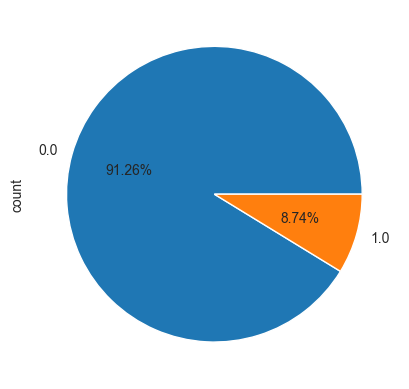

In [5]:
y.value_counts().plot.pie(autopct='%0.2f%%')

In [6]:
print(f"contamination {y.value_counts()[1]/len(y):.2f}")

contamination 0.09


In [7]:
def train_model_random_forest(x_train:pd.DataFrame, y_train:pd.DataFrame, x_test:pd.DataFrame):
    rf=RandomForestClassifier(n_estimators=100,random_state=42,class_weight='balanced',n_jobs=-1)
    rf.fit(x_train,y_train)
    y_pred=rf.predict(x_test)
    y_proba=rf.predict_proba(x_test)[:,1]
    return rf,y_pred,y_proba

In [8]:
def train_model_isolation_forest(x_train:pd.DataFrame, true_labels:pd.DataFrame, contamination=0.1):
    iso = IsolationForest(contamination=contamination, random_state=42,n_jobs=-1)  # Expect ~10% anomalies
    iso.fit(df)
    predicted_labels = iso.predict(df)
    predicted_labels=[0 if x == 1 else 1 for x in predicted_labels]
    print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Anomaly']))

In [9]:
def model_evaluation(y_test:pd.DataFrame,y_pred:pd.DataFrame,y_proba:np.ndarray,model_name:str)->None:
    '''
    Metrics for model evaluation and visualization
    :param y_test: pd.DataFrame contains test labels
    :param y_pred: pd.DataFrame contains predicted labels
    :param y_proba:np.ndarray contains predicted probabilities
    :param model_name: str, name of the model
    :return: None
    '''
    print(f"Model Evaluation for {model_name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Average Precision Score:", average_precision_score(y_test, y_proba))
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"../reports/figures/{model_name}_confusion_matrix.png")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend()
    plt.savefig(f"../reports/figures/{model_name}_roc_curve.png")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f"Avg Precision = {average_precision_score(y_test, y_proba):.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.savefig(f"../reports/figures/{model_name}_precision_recall_curve.png")
    plt.show()

In [10]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=42)

<class 'numpy.ndarray'>
Model Evaluation for Random Forest
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182557
         1.0       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000

ROC AUC Score: 0.9999999985868351
Average Precision Score: 0.9999999835675338


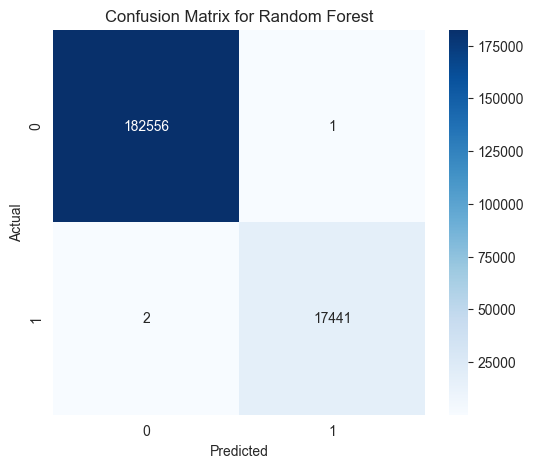

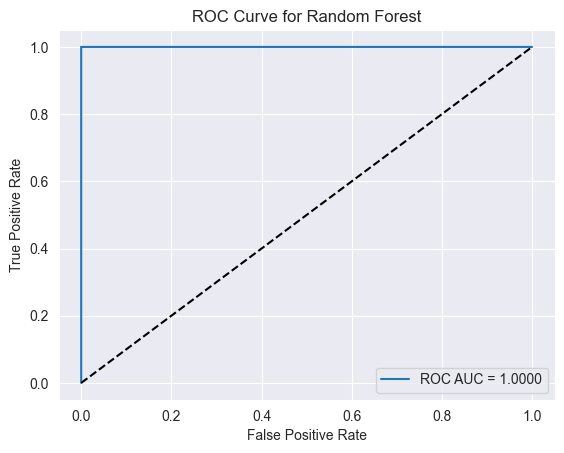

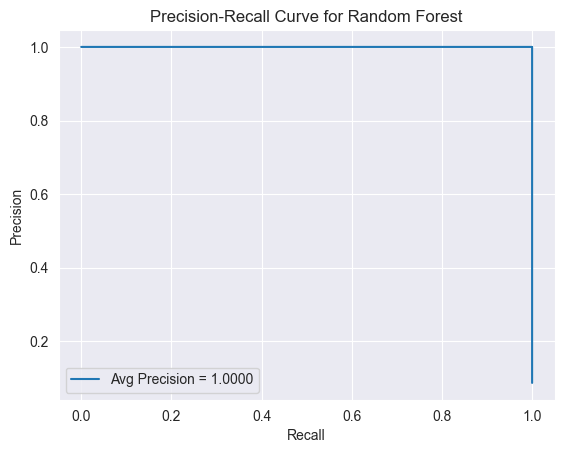

In [11]:
model,y_pred, y_proba = train_model_random_forest(X_train, y_train, X_test)
joblib.dump(model, '../weights/models/random_forest_model.pkl')
print(type(y_proba))
model_evaluation(y_test,y_pred,y_proba,'Random Forest')

In [12]:

train_model_isolation_forest(X,y,contamination=0.1)

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94    912597
     Anomaly       0.43      0.49      0.46     87403

    accuracy                           0.90   1000000
   macro avg       0.69      0.71      0.70   1000000
weighted avg       0.91      0.90      0.90   1000000



``` shell
def undersample(x:pd.DataFrame, y:pd.DataFrame,sampling_strategy=1)->Tuple[pd.DataFrame,pd.DataFrame]:
    '''
    Undersampling the majority class to match the minority class
    :param x: pd.DataFrame, training data
    :param y: pd.DataFrame, training labels
    :sampling_strategy: str or float, sampling strategy, default is 1
    :return: pd.DataFrame, undersampled training data, pd.DataFrame, undersampled training labels
    '''
    rus=RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    x_rus,y_rus=rus.fit_resample(x, y)
    return x_rus,y_rus

def smote_oversampling(x:pd.DataFrame,y:pd.DataFrame,sampling_strategy='auto')->Tuple[pd.DataFrame,pd.DataFrame]:
    sm=SMOTE(sampling_strategy=sampling_strategy,random_state=42)
    x_ros,y_ros=sm.fit_resample(x,y)
    return x_ros,y_ros

def oversample(x:pd.DataFrame,y:pd.DataFrame,sampling_strategy='not majority')->Tuple[pd.DataFrame,pd.DataFrame]:
    '''
    Undersampling the majority class to match the minority class
    :param x: pd.DataFrame, training data
    :param y: pd.DataFrame, training labels
    :param sampling_strategy: str or float, sampling strategy, default is 1
    :return: pd.DataFrame, undersampled training data, pd.DataFrame, undersampled training labels
    '''
    ros=RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    x_ros,y_ros=ros.fit_resample(x,y)
    return x_ros,y_ros



cdf=load_dataset('../data/processed_data/credit_card_fraud_processed_dataset.csv')
X=cdf.drop('IsFraud',axis=1)
Y=cdf['IsFraud']
'''
undersampling and splitting dataset
'''
x_rus,y_rus=undersample(X,Y)
x_rus_train,x_rus_test,y_rus_train,y_rus_test=train_test_split(x_rus,y_rus,test_size=0.2,random_state=42)
'''
oversampling and splitting dataset
'''
x_ros,y_ros=oversample(X,Y)
x_ros_train,x_ros_test,y_ros_train,y_ros_test=train_test_split(x_ros,y_ros,test_size=0.2,random_state=42)
model_undersample,y_pred_undersample,y_proba_undersample=train_model_random_forest(x_rus_train,y_rus_train,x_rus_test)
model_evaluation(y_rus_test,y_pred_undersample,y_proba_undersample,'Random Forest with Undersampling')
model_oversample,y_pred_oversample,y_proba_oversample=train_model_random_forest(x_ros_train,y_ros_train,x_ros_test)
model_evaluation(y_ros_test,y_pred_oversample,y_proba_oversample,'Random Forest with Oversampling')
```